<a href="https://colab.research.google.com/github/paulagm12/DSPS_PGalvezMolina/blob/main/HW10_PGalvezMolina/HW10_PGalvezMolina_PINN_Burgers_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
tf.__version__

'2.14.0'

In [2]:
import scipy
from scipy import io
from scipy.interpolate import griddata
import pylab as pl

In [3]:
!wget https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat

--2023-12-12 01:28:54--  https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat [following]
--2023-12-12 01:28:54--  https://raw.githubusercontent.com/maziarraissi/PINNs/master/appendix/Data/burgers_shock.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 207944 (203K) [application/octet-stream]
Saving to: ‘burgers_shock.mat’

burgers_shock.mat   100%[===================>] 203.07K  --.-KB/s    in 0.004s  

2023-12-12 01:28:54 (50.8 MB/s) - ‘burgers_shock.mat’ s

(100,) (256,) (256, 100)


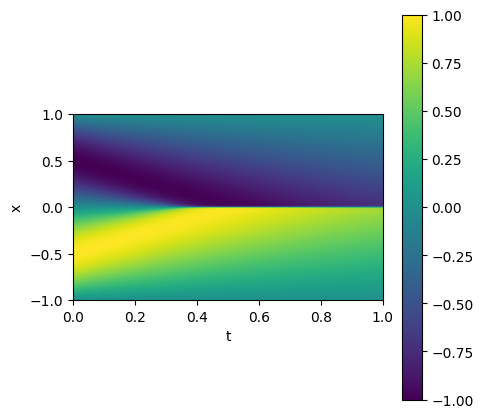

In [4]:
### what is the solution that we want? read in the data

# loading in a file saved as a binary (?) in mathematica
data = scipy.io.loadmat('burgers_shock.mat')

data.keys()

t = data['t'].flatten() #time
x = data['x'].flatten() #position
Z = np.real(data['usol']) #solution of Burger's Ee

print(t.shape, x.shape, Z.shape)

ax = pl.figure(figsize=(5,5)).add_subplot(111)
cb = ax.imshow(Z[::-1],extent=[0,1,-1,1], clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3)
pl.colorbar(cb);


### **Fig. 1.** Colormap of viscosity with respect to time and position. This is the analytical solution we are trying to obtain through training a neural network. Greater velocity is represented in lighter colors (yellow) and lower viscosity in darker colors (blue).

# PROBLEM SETUP: BURGER'S EQUATIONS
$$
\begin{align}
    \partial_t u (t,x) + \mathcal{N}[u](t,x) &= 0, && (t,x) \in (0,T] \times \mathcal{D},\\
    u(0,x) &= u_0(x) \quad && x \in \mathcal{D},
\end{align}
$$


$$
\begin{align}
        \hspace{7em} u(t,x) &= u_b(t,x)  && \quad (t,x) \in (0,T] \times \partial \mathcal{D},
\end{align}
$$


# SPECIFIC CASE: LIMIT REGIME AND SET VISCOSITY TO $\nu=0.01/\pi$

$$
\begin{aligned}
    \partial_t u + u \, \partial_x u - (0.01/\pi) \, \partial_{xx} u &= 0, \quad &&\quad (t,x) \in (0,1] \times (-1,1),&&\mathrm{eq.1}\\
   u(0,x) &= - \sin(\pi \, x),                 \quad &&\quad x \in [-1,1],&\mathrm{eq.2}\\
   u(t,-1) = u(t,1) &= 0,                      \quad &&\quad t \in (0,1].
\end{aligned}
$$

In [5]:
tf.random.set_seed(123)
pi = tf.constant(np.pi, dtype="float32")

In [6]:
def fun_u_0(x): #u(0,x) eq 2
  return -tf.sin(pi * x)

def fun_u_b(t, x): #u(t,x) - set up container
  return tf.zeros((x.shape[0], 1), dtype="float32")

def fun_res(u, u_t, u_x, u_xx): #deruvatuve equation eq 1 - u_. is the derivative w respect to .
  return tf.abs(u_t + u * u_x - 0.01 / pi * u_xx)

In [7]:
#number of points we are using for training and predicting
n_0 = 50 #points at t=0 -> initial conditions
n_b = 50 #points at b=1;-1] -> boundary conditions
n_r = 10000

#boundaries
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

# get random data in x at t=0


In [8]:
t_0 = tf.ones((n_0, 1), dtype="float32") * tmin
x_0 = tf.random.uniform((n_0, 1), xmin, xmax, dtype="float32")
X_0 = tf.concat([t_0, x_0], axis=1)
X_0

<tf.Tensor: shape=(50, 2), dtype=float32, numpy=
array([[ 0.        , -0.7476938 ],
       [ 0.        ,  0.14550257],
       [ 0.        , -0.4013734 ],
       [ 0.        ,  0.09236717],
       [ 0.        ,  0.44103146],
       [ 0.        ,  0.5779066 ],
       [ 0.        , -0.3846376 ],
       [ 0.        , -0.03657794],
       [ 0.        ,  0.30755043],
       [ 0.        , -0.7580149 ],
       [ 0.        , -0.27416515],
       [ 0.        , -0.5102    ],
       [ 0.        , -0.54608774],
       [ 0.        ,  0.04020071],
       [ 0.        ,  0.7369325 ],
       [ 0.        , -0.42762113],
       [ 0.        , -0.01630592],
       [ 0.        ,  0.34997678],
       [ 0.        , -0.11965895],
       [ 0.        , -0.02140164],
       [ 0.        ,  0.6112704 ],
       [ 0.        ,  0.7948568 ],
       [ 0.        ,  0.27323198],
       [ 0.        ,  0.00240111],
       [ 0.        , -0.03221846],
       [ 0.        ,  0.50451255],
       [ 0.        ,  0.6129718 ],
      

# evaluate initial condition at x_0

In [9]:
u_0 = fun_u_0(x_0) #eq 2
u_0

<tf.Tensor: shape=(50, 1), dtype=float32, numpy=
array([[ 0.7122112 ],
       [-0.44135648],
       [ 0.95238096],
       [-0.28612474],
       [-0.9828893 ],
       [-0.97019774],
       [ 0.93504095],
       [ 0.11466026],
       [-0.8227306 ],
       [ 0.6890799 ],
       [ 0.7587001 ],
       [ 0.9994866 ],
       [ 0.9895364 ],
       [-0.12595879],
       [-0.7355314 ],
       [ 0.97425926],
       [ 0.05120417],
       [-0.89097345],
       [ 0.36712813],
       [ 0.0671846 ],
       [-0.9395213 ],
       [-0.60077995],
       [-0.756787  ],
       [-0.00754325],
       [ 0.10104453],
       [-0.9998995 ],
       [-0.9376773 ],
       [ 0.06082507],
       [ 0.49481562],
       [-0.48312566],
       [ 0.94241977],
       [-0.5245297 ],
       [-0.8038826 ],
       [ 0.8135314 ],
       [-0.8391674 ],
       [-0.85155034],
       [-0.9423501 ],
       [ 0.77795136],
       [ 0.5914944 ],
       [ 0.09085801],
       [ 0.49529788],
       [ 0.4755419 ],
       [ 0.01998235],
     

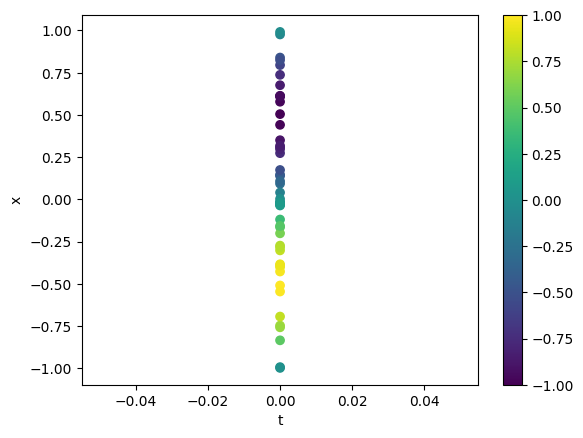

In [10]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.colorbar()
pl.xlabel("t")
pl.ylabel("x");

### **Fig. 2.** Scatterplot of position at time 0 and corresponding velocity at such position at initial time. Greater velocity is represented in lighter colors (yellow) and lower velocity in darker colors (blue).

# get data at boundaries of x at random t's



In [11]:
t_b = tf.random.uniform((n_b, 1), tmin, tmax, dtype="float32")
x_b = xmin + (xmax - xmin) * tf.keras.backend.random_bernoulli((n_b, 1), 0.5, dtype="float32")
X_b = tf.concat([t_b, x_b], axis=1)
X_b

<tf.Tensor: shape=(50, 2), dtype=float32, numpy=
array([[ 0.88968754, -1.        ],
       [ 0.12354946, -1.        ],
       [ 0.7718717 ,  1.        ],
       [ 0.6850728 ,  1.        ],
       [ 0.6442598 ,  1.        ],
       [ 0.07745004,  1.        ],
       [ 0.75058556,  1.        ],
       [ 0.6250843 ,  1.        ],
       [ 0.00772953,  1.        ],
       [ 0.55370283,  1.        ],
       [ 0.83894694,  1.        ],
       [ 0.43658102,  1.        ],
       [ 0.9566101 ,  1.        ],
       [ 0.7588576 ,  1.        ],
       [ 0.8964343 , -1.        ],
       [ 0.44467843, -1.        ],
       [ 0.3243779 ,  1.        ],
       [ 0.3443855 ,  1.        ],
       [ 0.91262174, -1.        ],
       [ 0.77731085, -1.        ],
       [ 0.899588  ,  1.        ],
       [ 0.50426483,  1.        ],
       [ 0.45032525, -1.        ],
       [ 0.5939442 , -1.        ],
       [ 0.71862614,  1.        ],
       [ 0.91657436, -1.        ],
       [ 0.98180914, -1.        ],
      

# evaluate data at boundaries of x at random t's


In [12]:
u_b = fun_u_b(t_b, x_b)
u_b

<tf.Tensor: shape=(50, 1), dtype=float32, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)>

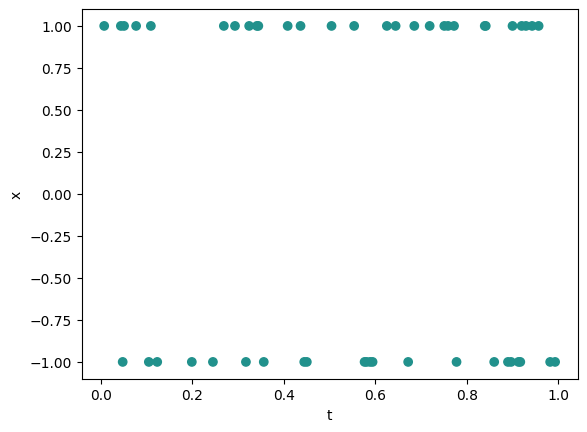

In [13]:
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

### **Fig. 3.** Scatterplot of position and time and corresponding viscosity at boundary positions (x = 1 and x = -1). As the viscosity is given by the u_b function described previously, all viscosities at the position boundary are 0.

# get points inside the space at random where the function will be predicted

In [14]:
t_r = tf.random.uniform((n_r, 1), tmin, tmax, dtype="float32")
x_r = tf.random.uniform((n_r, 1), xmin, xmax, dtype="float32")
X_r = tf.concat([t_r, x_r], axis=1)
X_r

<tf.Tensor: shape=(10000, 2), dtype=float32, numpy=
array([[ 0.48962688, -0.15719008],
       [ 0.5857923 ,  0.16138387],
       [ 0.36451697, -0.43461084],
       ...,
       [ 0.9338294 ,  0.9995079 ],
       [ 0.11166203, -0.28287673],
       [ 0.00506091,  0.7726338 ]], dtype=float32)>

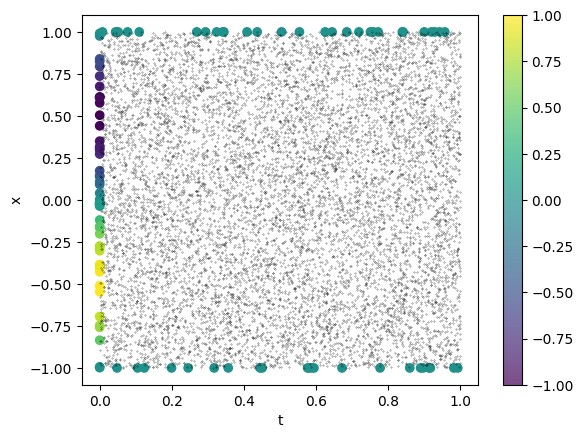

In [15]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c="k", marker='.', s=0.3, alpha=0.7, clim=(-1,1))
pl.colorbar()
pl.xlabel("t")
pl.ylabel("x");

### **Fig. 4.** Scatterplot of velocity at a given position and time. Greater velocity is represented in lighter colors (yellow) and lower velocity in darker colors (blue).The boundaries are given data from the initial conditions of the box, the points in between are uninformative, these will be predicted.

In [16]:
#put boundary conditionns together
X = tf.concat([X_0, X_b], axis=0)
y = tf.concat([u_0, u_b], axis=0)
X.shape, y.shape


(TensorShape([100, 2]), TensorShape([100, 1]))

# create the model with simple loss

In [17]:
nnmodel = tf.keras.Sequential()

#input layer with 2 neurons for 2 dimensions
nnmodel.add(tf.keras.Input(2))

#8 hidden layers
for i in range(8):
  nnmodel.add(tf.keras.layers.Dense(20, activation = "tanh"))

#output layer is 1D
nnmodel.add(tf.keras.layers.Dense(1))


In [18]:
optim = tf.keras.optimizers.Adam(learning_rate=0.001)
def custom_loss(truth, prediction):
  return tf.reduce_mean(tf.square(truth-prediction))

In [19]:
nnmodel.compile(loss=custom_loss, optimizer=optim)

## train the model

In [20]:
history = nnmodel.fit(X, y, epochs=1000)

Epoch 1/1000
4/4 [==============================] - 11s 16ms/step - loss: 0.2210
Epoch 2/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.2102
Epoch 3/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1916
Epoch 4/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1838
Epoch 5/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1825
Epoch 6/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1781
Epoch 7/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1736
Epoch 8/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1685
Epoch 9/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1647
Epoch 10/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1593
Epoch 11/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1504
Epoch 12/1000
4/4 [==============================] - 0s 5ms/step - loss: 0.1439
Epoch 13/1000
4/4 [============================

Text(0, 0.5, 'loss')

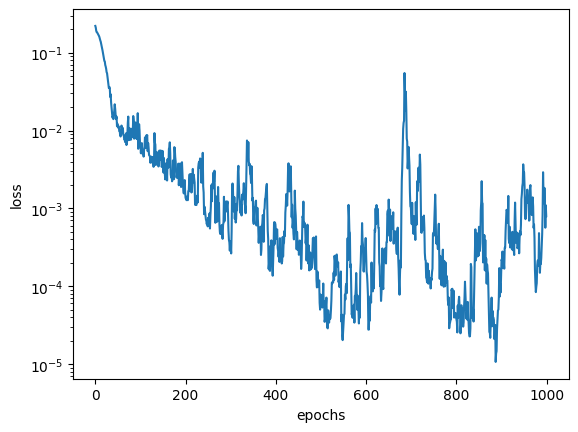

In [21]:
pl.semilogy(history.history["loss"])
pl.xlabel("epochs")
pl.ylabel("loss")

### **Fig. 5.** Line plot of loss function over epochs for the model with 8 hidden layers for prediction of velocity given initial conditions for Burger's equation with viscosity of 0.01 over pi.The loss function trends downwards as the model learns, however it is still noisy, probably due to the learning rate being used.

## see the result

In [22]:
nnmodel.predict(tf.concat([t_r, x_r], axis=1))

313/313 [==============================] - 1s 3ms/step


array([[-0.03482235],
       [-0.0451923 ],
       [-0.00221244],
       ...,
       [-0.01573727],
       [ 0.10172155],
       [-0.666218  ]], dtype=float32)

313/313 [==============================] - 1s 3ms/step


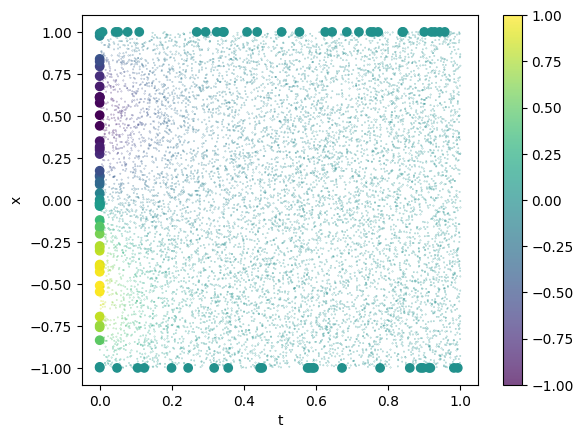

In [23]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c=nnmodel.predict(tf.concat([t_r, x_r], axis=1)), marker='.',
           s=0.2, alpha=0.7, clim=(-1,1))
pl.colorbar()
pl.xlabel("t")
pl.ylabel("x");

### **Fig. 6.** Scatterplot of velocity at a given position and time with analyitical inital conditions, and 1,000 random points predicted by the trained model. The model predicts a zero velocity throughout, which is a fair guess as all the information at different times, except at t = 0, is zero.

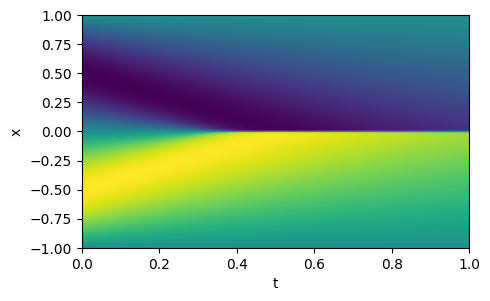

In [24]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
cb = ax.imshow(Z[::-1],extent=[0,1,-1,1], clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3);


### **Fig. 7.** Same as Fig. 1, used for comparison with the early version of trained nn.

show the accuracy for every point that you solved for

8/8 [==============================] - 0s 3ms/step


-13.189995160936544

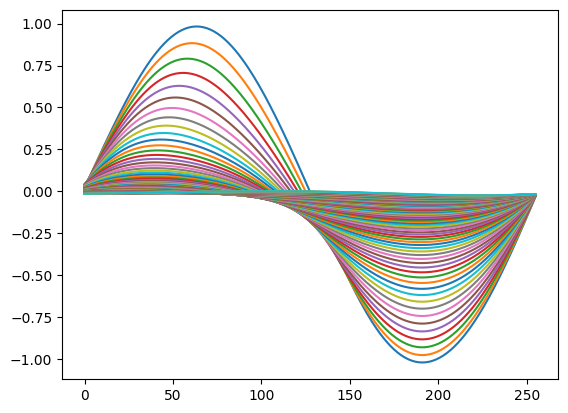

In [25]:
def L1accuracy(t, x, model):
  tmp_ = np.zeros((x.shape[0], 2), dtype="float32")
  tmp_[:,1] += x
  acc = 0
  for tt in range(t.shape[0]):
    tmp_[:,0] = t[tt]
    pl.plot(model.predict(tmp_))
    acc += (model.predict(tmp_) - Z[:,tt]).sum()


  return acc / np.prod(t.shape[0] * x.shape[0])
L1accuracy(t, x, nnmodel)

### **Fig. 8.** Scatter plots of velocity per position bin at a fixed time. Each graph (color) represents how the velocity is changing at a fixed time as the position changes, such change in position is iterated in the same order for each plot (line). The graph shows that velocity changes sinusoidally as function of position, but for other times that is not the case, rather it seems like it remains the same despite the change in location.

8/8 [==============================] - 0s 2ms/step


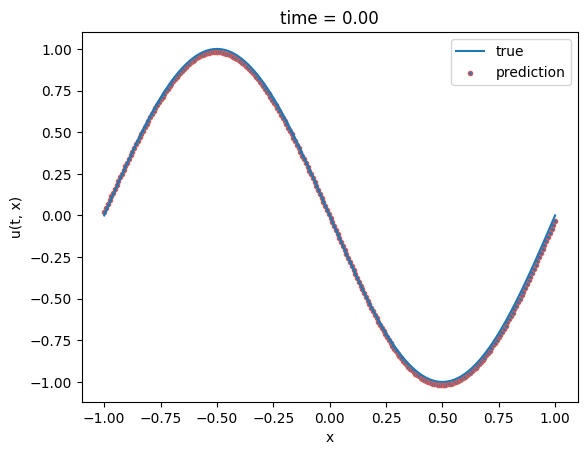

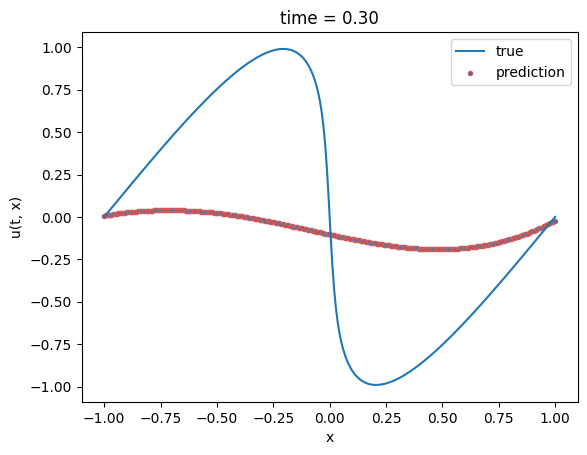

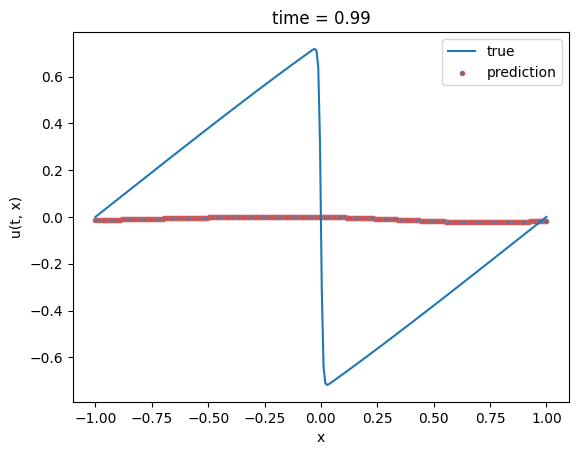

In [26]:
tmp_ = np.zeros((x.shape[0], 2), dtype="float32")
tmp_[:,1] += x
inds = [0, 30, -1]
for i in range(3):
  pl.figure()
  pl.title("time = %.2f"%t[inds[i]])
  pl.plot(x, Z[:,inds[i]], label="true")
  tmp_[:,0] = t[inds[i]]
  pl.scatter(x, nnmodel.predict(tmp_), marker='.', edgecolors="IndianRed",
             label="prediction")
  pl.xlabel("x")
  pl.ylabel("u(t, x)")
  pl.legend();


### **Fig. 9.** Line graphs of preduction vs. true value of velocity over position at time 0, 0.30 and 0.99. The plots exhibit a loss in accuracy as time progresses.

# create the model with complete loss

In [27]:
def get_pde(model, X_r):

  with tf.GradientTape(persistent=True) as tape:
      t, x = X_r[:,0:1], X_r[:,1:2]
      tape.watch(t)
      tape.watch(x)
      u = model(tf.concat([t, x], axis=1))
      u_x = tape.gradient(u,x)
      #print(u_x)
  u_t = tape.gradient(u, t)
  u_xx = tape.gradient(u_x, x)

  del tape # to save some memory

  return u, u_t, u_x, u_xx


In [28]:
def custom_loss(model, X_r, X, y):
    u_pred = model(X)
    loss = tf.reduce_mean(tf.square(y - u_pred))
    u_pred, u_t, u_x, u_xx = get_pde(model, X_r)
    resids = fun_res(u_pred, u_t, u_x, u_xx)
    loss += tf.reduce_mean(tf.square(resids))
    return loss


In [34]:
def get_grad(model, X_r, X, y):
    # model derivatives for backprop
    with tf.GradientTape(persistent=True) as tape:
      tape.watch(model.trainable_variables)
      loss = custom_loss(model, X_r, X, y)

    g = tape.gradient(loss, model.trainable_variables)

    return loss, g

## train the model

In [35]:
import copy

In [36]:
pinn = tf.keras.Sequential()

#input layer with 2 neurons for 2 dimensions
pinn.add(tf.keras.Input(2))
#hidden layers
for i in range(8):
  pinn.add(tf.keras.layers.Dense(20, activation='tanh'))
#output layer is 1D
pinn.add(tf.keras.layers.Dense(1))

In [37]:
@tf.function
def train_step(model, X_r, X, y):

  loss, grad = get_grad(model, X_r, X, y)
  optim.apply_gradients(zip(grad, model.trainable_variables))
  return loss

optim = tf.keras.optimizers.Adam(learning_rate=0.005)
pinn.compile(loss=custom_loss, optimizer=optim) #change the loss and optimization

history = []
Nepochs = 5000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))



It 00000: loss = 2.45576084e-01
It 00050: loss = 1.18822567e-01
It 00100: loss = 8.60028341e-02
It 00150: loss = 9.22414362e-02
It 00200: loss = 6.04130626e-02
It 00250: loss = 5.46253398e-02
It 00300: loss = 5.01359329e-02
It 00350: loss = 4.95609269e-02
It 00400: loss = 5.19720837e-02
It 00450: loss = 9.55387428e-02
It 00500: loss = 3.09319105e-02
It 00550: loss = 9.91521478e-02
It 00600: loss = 3.15926820e-02
It 00650: loss = 1.79964956e-02
It 00700: loss = 2.77451277e-02
It 00750: loss = 1.94229074e-02
It 00800: loss = 7.07408227e-03
It 00850: loss = 1.59835406e-02
It 00900: loss = 9.54457745e-03
It 00950: loss = 2.95188576e-02
It 01000: loss = 4.47360938e-03
It 01050: loss = 2.43431027e-03
It 01100: loss = 2.99337110e-03
It 01150: loss = 1.87819381e-03
It 01200: loss = 5.33623155e-03
It 01250: loss = 3.12602194e-03
It 01300: loss = 7.35171791e-03
It 01350: loss = 1.05865079e-03
It 01400: loss = 2.94327131e-03
It 01450: loss = 1.16152421e-03
It 01500: loss = 1.05696926e-02
It 01550

313/313 [==============================] - 1s 3ms/step


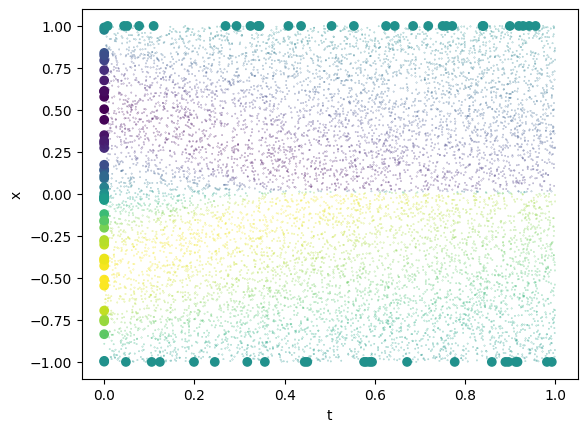

In [38]:
pl.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
pl.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
pl.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)), marker='.',
           s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");

### **Fig. 10.** Scatterplot of velocity at a given position and time with analyitical inital conditions, and 1,000 random points predicted by the physically informed trained model. The model predicts velocities that more closely resemble the desired output shown in Figs. 1 and 7.

313/313 [==============================] - 1s 2ms/step


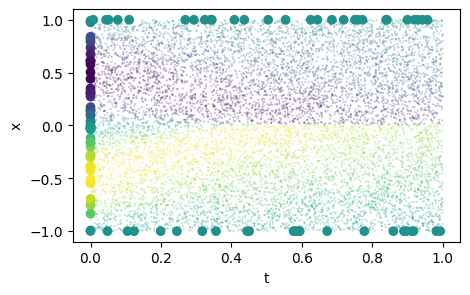

In [39]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
pl.xlabel("t")
pl.ylabel("x");
ax.set_aspect(0.3);

### **Fig. 11.** Same figure as Fig. 10 only that it was resized to make it more comparable to Figs. 1 and 7 and show the close resemblance.

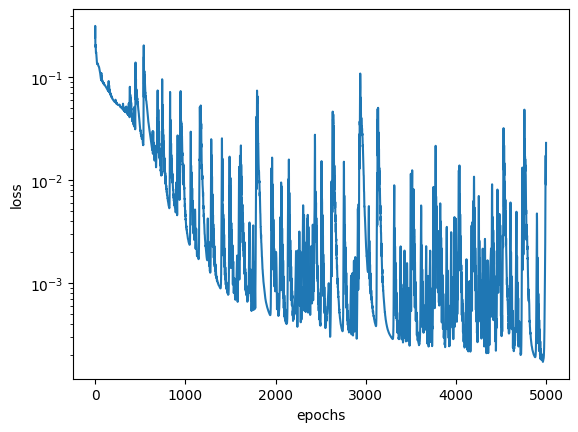

In [40]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss");

### **Fig. 12.** Line plot of loss function over epochs for physically informed model for prediction of velocity given initial conditions for Burger's equation with viscosity of 0.01 over pi.The customized loss function trends downwards as the model learns, however it is very noisy, probably (as in Fig. 5) due to the large learning rate chosen.

8/8 [==============================] - 0s 3ms/step


3.9772437776064695

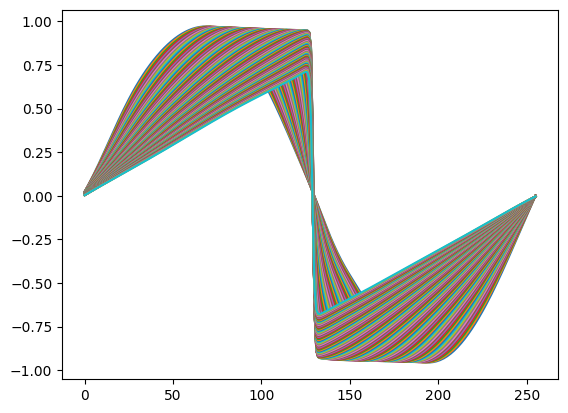

In [41]:
L1accuracy(t, x, pinn)

### **Fig. 13.** Scatter plots of velocity per position bin at a fixed time of the predictions of the physically informed model. As in Fig. 8, each graph (color) represents how the velocity is changing at a fixed time as the position changes, such change in position is iterated in the same order for each plot (line). The graph shows that velocity has a dramatic response to the change in position at specified times.

# adjust the learning rate and trin some more
the loss was awfully noisy

In [42]:
from tensorflow.keras.backend import set_value
set_value(pinn.optimizer.lr, 0.0001)

In [43]:
Nepochs = 10000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))


It 00000: loss = 3.57179679e-02
It 00050: loss = 8.06333614e-04
It 00100: loss = 4.99696936e-04
It 00150: loss = 4.11034911e-04
It 00200: loss = 3.50051705e-04
It 00250: loss = 3.04875255e-04
It 00300: loss = 2.70923600e-04
It 00350: loss = 2.45698437e-04
It 00400: loss = 2.27028024e-04
It 00450: loss = 2.13006846e-04
It 00500: loss = 2.02284980e-04
It 00550: loss = 1.93953747e-04
It 00600: loss = 1.87383965e-04
It 00650: loss = 1.82124320e-04
It 00700: loss = 1.77846669e-04
It 00750: loss = 1.74312547e-04
It 00800: loss = 1.71343898e-04
It 00850: loss = 1.68810569e-04
It 00900: loss = 1.66618382e-04
It 00950: loss = 1.64693542e-04
It 01000: loss = 1.62982222e-04
It 01050: loss = 1.61443357e-04
It 01100: loss = 1.60045485e-04
It 01150: loss = 1.58764669e-04
It 01200: loss = 1.57583214e-04
It 01250: loss = 1.56483293e-04
It 01300: loss = 1.55454647e-04
It 01350: loss = 1.54484311e-04
It 01400: loss = 1.53568981e-04
It 01450: loss = 1.52697059e-04
It 01500: loss = 1.51865010e-04
It 01550

Text(0, 0.5, 'loss')

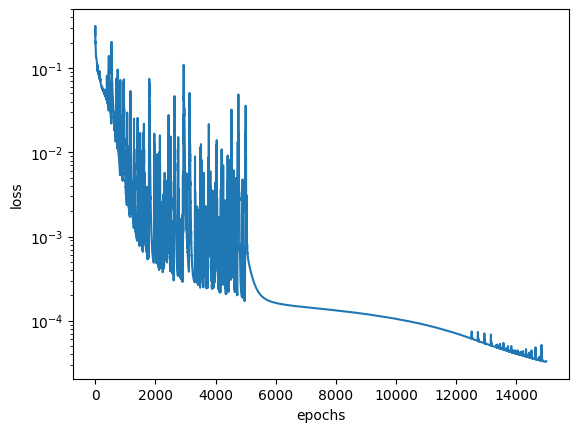

In [44]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss")

### **Fig. 14.** Line plot of concatenated loss function over 14,000 epochs for physically informed model for prediction of velocity given initial conditions for Burger's equation with viscosity of 0.01 over pi. Building on the previous training, the learning rate was lowered and ran for 10,000 epochs more. This changing of the learning rate yielded a smoother learning curve although it is clearly not stable yet.

313/313 [==============================] - 1s 3ms/step


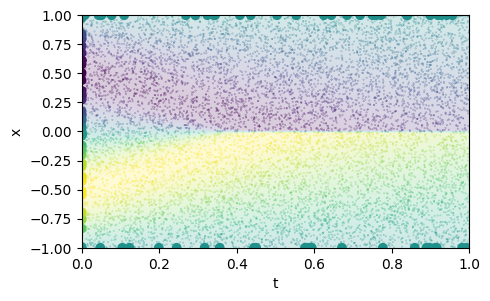

In [53]:
ax = pl.figure(figsize=(5,5)).add_subplot()
ax.imshow(Z[::-1],extent=[0,1,-1,1], alpha=0.2)
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3);

### **Fig. 15.** Scatterplot of velocity at a given position and time with analyitical inital conditions, and 1,000 random points predicted by the physically informed trained model after retraining with a smaller learning rate. The model predicts velocities that more closely resemble the desired output shown in Figs. 1 and 7 than those before.

In [46]:
Nepochs = 10000
for i in range(Nepochs):
  loss = train_step(pinn, X_r, X, y)
  history.append(loss.numpy())
  # Output current loss after 50 iterates
  if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))

It 00000: loss = 3.34433316e-05
It 00050: loss = 3.21445223e-05
It 00100: loss = 3.17915765e-05
It 00150: loss = 3.14815916e-05
It 00200: loss = 3.34024880e-05
It 00250: loss = 3.09894203e-05
It 00300: loss = 3.05691246e-05
It 00350: loss = 3.09726893e-05
It 00400: loss = 3.05048943e-05
It 00450: loss = 3.00986285e-05
It 00500: loss = 2.95717691e-05
It 00550: loss = 3.33939461e-05
It 00600: loss = 2.89445998e-05
It 00650: loss = 2.89244945e-05
It 00700: loss = 2.83996924e-05
It 00750: loss = 2.81448793e-05
It 00800: loss = 2.78991720e-05
It 00850: loss = 2.77737454e-05
It 00900: loss = 2.74249051e-05
It 00950: loss = 2.79521846e-05
It 01000: loss = 2.69619268e-05
It 01050: loss = 2.67362138e-05
It 01100: loss = 2.71016088e-05
It 01150: loss = 2.63050824e-05
It 01200: loss = 5.20721333e-05
It 01250: loss = 2.59166754e-05
It 01300: loss = 2.57026331e-05
It 01350: loss = 2.55027771e-05
It 01400: loss = 2.53282342e-05
It 01450: loss = 2.51170877e-05
It 01500: loss = 2.60087345e-05
It 01550

Text(0, 0.5, 'loss')

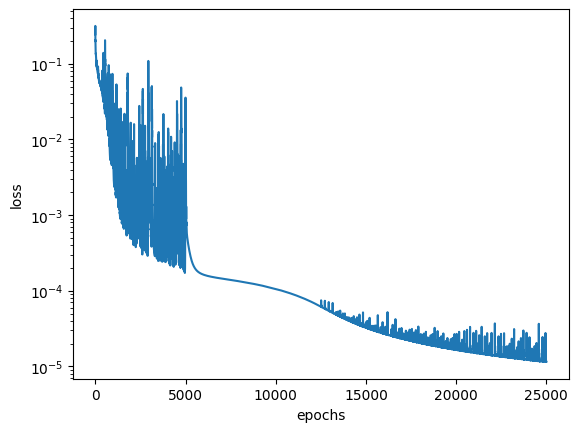

In [47]:
pl.semilogy(history)
pl.xlabel("epochs")
pl.ylabel("loss")

### **Fig. 16.** Line plot of concatenated loss function over 25,000 epochs for physically informed model for prediction of velocity given initial conditions for Burger's equation with viscosity of 0.01 over pi. Building on the previous training, the training ran for 11,000 epochs more. This longer period of training of showed that learning is still happening.

## final result

8/8 [==============================] - 0s 2ms/step


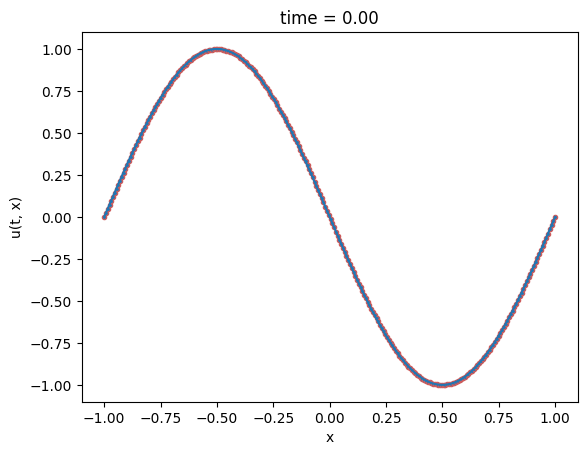

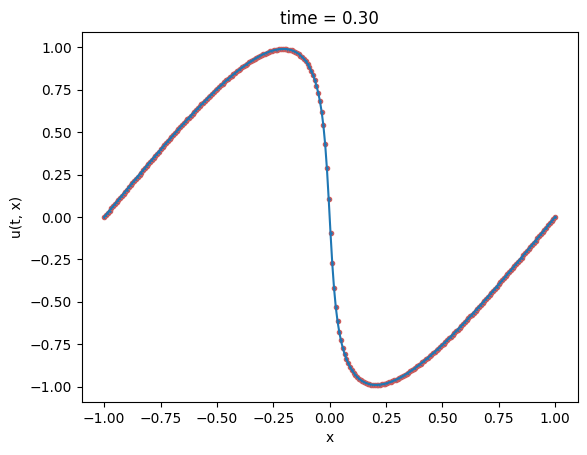

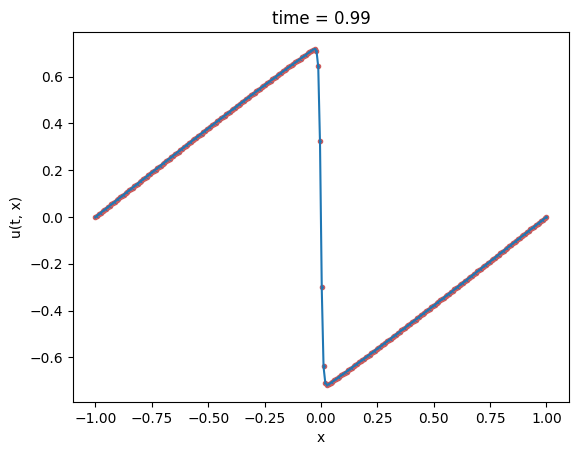

In [48]:
for i in range(3):
  pl.figure()
  pl.title("time = %.2f"%t[inds[i]])
  pl.plot(x, Z[:,inds[i]])
  tmp_[:,0] = t[inds[i]]
  pl.scatter(x, pinn.predict(tmp_), marker='.', edgecolors="IndianRed")
  pl.xlabel("x")
  pl.ylabel("u(t, x)");

### **Fig. 17.** Line graphs of preduction vs. true value of velocity over position at time 0, 0.30 and 0.99 for the physically informed model trained for over 25,000 epochs with diffferent initial and final learning rates. The plots exhibit an almost perfect correlation between predicted and expected values for the velocity (u) given the position (x) at fixed times.

313/313 [==============================] - 1s 2ms/step


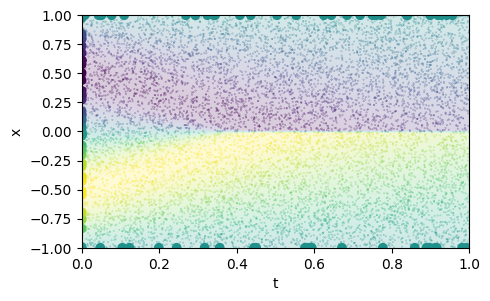

In [49]:
ax = pl.figure(figsize=(5,5)).add_subplot(111)
ax.imshow(Z[::-1], extent=[0,1,-1,1], alpha=0.2)
ax.scatter(t_0, x_0, c=u_0, marker='o', clim=(-1,1))
ax.scatter(t_b, x_b, c=u_b, marker='o', clim=(-1,1))
ax.scatter(t_r, x_r, c=pinn.predict(tf.concat([t_r, x_r], axis=1)),
           marker='.', s=0.2, alpha=0.7, clim=(-1,1))
ax.set_xlabel("t")
ax.set_ylabel("x");
ax.set_aspect(0.3)
pl.colorbar();

### **Fig. 18.** Final scatterplot of velocity at a given position and time with analyitical inital conditions, and 1,000 random points predicted by the physically informed trained model after retraining with a smaller learning rate over a larger number of epochs. The figure closely matches that exhibited in Figs. 1 and 7.

8/8 [==============================] - 0s 2ms/step


-0.03363617405311879

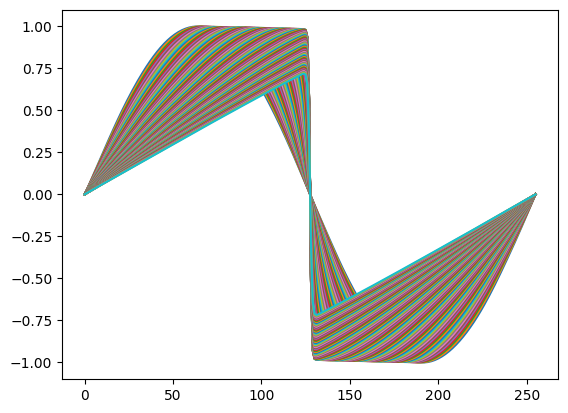

In [50]:
L1accuracy(t, x, pinn)

### **Fig. 19.** Scatter plots of velocity per position bin at a fixed time of the predictions of the physically informed model trained over a 25,000 epochs with different initial and final learning rates. As in Figs. 8 and 13, each graph (color) represents how the velocity is changing at a fixed time as the position changes, such change in position is iterated in the same order for each plot (line). The graph shows that velocity has a dramatic response to the change in position at specified times and change in time has a smaller impact on the change in velocity.